In [5]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import seaborn as sns

In [6]:
np.random.seed(123)
np.set_printoptions(suppress=True) # Removes printing of scientific notation values
sns.set_theme()
sns.set_palette("viridis")

# Problem

Let us look at a problem that is a simple finite Markov Decision Process. 
Consider the following 5 x 5 grid:

![Gridworld](imgs/Gridworld.png)

## Define the problem

- The cells of the grid correspond to the the states of the environment. 
- At each cell, 4 actions are possible: _north_, _south_, _east_, _west_ - which deterministically cause the agent to move 1 cell in the respective direction on the grid.
- Actions that would the agent off the grid leave its location unchanges, but also result in a reward of -1.
- From state A, any action yields a reward of +10 and takes the agent to A'.
- From state B, any action yields a reward of +5 and takes the agent to B'.
- All other actions result in a reward of 0.

Find the Optimal Value Function using Q-Learning.

In [7]:
@dataclass
class Grid:
    x_min: int
    x_max: int
    y_min: int
    y_max: int
    x_size: int
    y_size: int

@dataclass
class Coordinate:
    x: int
    y: int

@dataclass
class Direction:
    x: int
    y: int

In [8]:
def _calc_reward(loc: Coordinate, grid: Grid, A, B) -> int:
    """
    This function takes the location of a state and returns the reward for it.

    Args:
        loc: current location of agent
        grid: specifications of grid
        A: Position A coordinate
        B: Position B coordinate
    
    Returns:
        reward: value assigned to the state based on environment

    """
    if loc == A: #Reward for position A
        reward = 10
    elif loc == B: #Reward for position B
        reward = 5
    elif loc.x < grid.x_min or loc.x > grid.x_max or loc.y < grid.y_min or loc.y > grid.y_max: #Negative reward outside grid
        reward = -1
    else: # Reward for all other states
        reward = 0
    return reward

In [9]:
def is_valid_loc(loc: Coordinate, grid: Grid) -> bool:
    """
    This function checks if the coordinate of the location is within the confines of the grid. 

    Args:
        loc: current location of agent
        grid: specifications of grid
    
    Returns: True if loc is valid, else False.
    """
    if loc.x < grid.x_min or loc.x > grid.x_max or loc.y < grid.y_min or loc.y > grid.y_max:
        return False
    else:
        return True

In [10]:
def move(loc: Coordinate, grid: Grid, action: int) -> (tuple, float):
    """
    This function takes the current location of agent and the proposed action and returns the next state it will be in.

    Args:
        loc: current location of agent
        action: direction in which agent shall move.
    
    Returns:
        next_loc: coordinate for next state on grid based on environment constraints
        reward: value assigned to the state based on environment

    """
    loc = Coordinate(loc[0], loc[1]) #Convert to Coordinate object for convenience
    A = Coordinate(1, 0) # Define special state A
    B = Coordinate(3, 0) # Define special state B
    Ap = Coordinate(1, 4) # Define special state A prime
    Bp = Coordinate(3, 2) # Define special state B prime
    reward = _calc_reward(loc, grid, A, B)
    if loc == A:
        proposed_loc = Ap
    elif loc == B:
        proposed_loc = Bp
    else:
        if action == 0:
            proposed_loc = Coordinate(loc.x, loc.y - 1)
        elif action == 1:
            proposed_loc = Coordinate(loc.x, loc.y + 1)
        elif action == 2:
            proposed_loc = Coordinate(loc.x + 1, loc.y)
        elif action == 3:
            proposed_loc = Coordinate(loc.x - 1, loc.y)

    if is_valid_loc(proposed_loc, grid):
        next_loc = proposed_loc
    else:
        next_loc = loc
    
    next_loc = tuple((next_loc.x, next_loc.y)) #Convert to tuple object for dict
    return next_loc, reward

In [11]:
def initialise_q(grid: Grid, actions: list) -> dict:
    """
    This function takes the grid and set of possible actions and initialises an empty Q table.

    Args:
        grid: specifications of grid
        actions: set of directions in which agent can move.
    
    Returns:
        q: Q Table
    """
    q = {}
    for x in range(grid.x_size):
        for y in range(grid.y_size):
            q[(x, y)] = {}
            for action in actions:
                q[(x, y)][action] = 0.
    return q

In [12]:
def choose_action(eta: float, q: dict, state: tuple, actions: list) -> int:
    """
    This function takes in args to return the next action based on the extent of 
    randomness or q-values one wants to use controlled by the eta parameter.

    Args:
        eta: specifications of grid
        q: Q Table
        state: Coordinate of current state
        actions: set of directions in which agent can move.
    
    Returns:
        action: N, S, E or W picked as an integer 0, 1, 2 or 3 respectively. 
    """
    next_action_choices = ["random", "argmax"]
    choice = np.random.choice(next_action_choices, 1, p=[eta, 1-eta])
    if choice == "random":
        action = np.random.choice(actions, 1)[0]
    elif choice == "argmax":
        action = np.argmax(list(q[state].values()))
    return action

In [13]:
def get_xy_direction(arrow: int) -> Coordinate:
    """
    Helper function that determines the direction in which to draw an arrow.

    Args:
        arrow: variable that defines the direction of the arrow based on N, S, E, W.
    
    Returns:
        direction: gives a coordinate in the direction of the arrow
    """
    if arrow == 0:
        direction = Direction(0, -1)
    elif arrow == 1:
        direction = Direction(0, 1)
    elif arrow == 2:
        direction = Direction(1, 0)
    elif arrow == 3:
        direction = Direction(-1, 0)
    return direction

In [39]:
def get_q_arr(q_star) -> np.ndarray:
    """
    Helper function that determines which action returns the max rewards for every state in the environment.

    Args:
        q_star: optimal policy
    
    Returns:
        q_star_arr: array of q values for each state in the environment.
    """
    q_star_arr = np.zeros((5, 5))
    states = list(q_star.keys())
    for state in states:
        directions = list(q_star[state].keys())
        max_q_val = 0.0
        for direction in directions:
            q_val = np.round(q_star[state][direction])
            if q_val >= max_q_val:
                max_q_val = q_val
                q_star_arr[state[1]][state[0]] = max_q_val
    return q_star_arr

In [16]:
def q_learning(grid: Grid, actions: list, alpha: float, eta: float, gamma: float, episodes: int, N: int) -> dict:
    """
    This function implements the Q Learning algorithm on the environment based on the hyper-parameters.

    Args:
        grid: specifications of grid
        actions: set of directions in which agent can move.
        alpha: learning rate
        eta: epsilon-greedy rate
        gamma: discount factor
        epsiodes: number of simulations
        N: number of steps
    
    Returns:
        q: store of q value for every combination of state and action. 
    """
    q = initialise_q(grid, actions) # Initialize q_table 
    states = list(q.keys())
    for i in range(episodes):
        state = random.choice(states) # Initialise state with random starting point
        for j in range(N):
            action = choose_action(eta, q, state, actions)
            next_state, reward = move(state, action)
            next_action = np.argmax(list(q[next_state].values()))
            q[state][action] = q[state][action] + alpha * (reward + gamma * (q[next_state][next_action]) - q[state][action])
            state = next_state
    return q

In [17]:
def plot_gridworld_results(q_star, q_star_arr):
    """
    Helper function that plots the grid with the arrows indicating the optimal policy that has been learned.

    Args:
        q_star: optimal policy
        q_star_arr: direction of arrows associated to the optimal policy.
    """
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(15, 7)
    fig.suptitle(fr"Gridworld states and directions, using Q-Learning")
    fig.supxlabel("x")
    fig.supylabel("y")
    axs[0].set_title(fr"$q_*$")
    axs[1].set_title(fr"$\pi_* directions$")
    sns.heatmap(q_star_arr, cmap='Spectral', annot=True, ax=axs[0])
    plt.imshow(q_star_arr, cmap='Spectral')
    states = list(q_star.keys())
    for state in states:
        arrows = np.argwhere(list(q_star[state].values()) == np.amax(list(q_star[state].values()))).flatten().tolist()
        for arrow in arrows:
            direction = get_xy_direction(arrow)
            plt.quiver(state[0], state[1], direction.x, -direction.y)
    plt.show()

In [40]:
eta = 0.1
alpha = 0.2
gamma = 0.9
episodes = 1000
N = 1000
actions = [0, 1, 2, 3] #Define actions: North, South, East, West
grid = Grid(x_min=0, x_max=4, y_min=0, y_max=4, x_size=5, y_size=5) #Define a 5 x 5 grid.

In [41]:
q_star = q_learning(grid, actions, alpha, eta, gamma, episodes, N)
q_star_arr = get_q_arr(q_star)


In [42]:
q_star

{(0, 0): {0: 19.779736758565047,
  1: 17.801763082708536,
  2: 21.977485287294503,
  3: 19.779736758565047},
 (0, 1): {0: 19.779736758565047,
  1: 16.021586774437676,
  2: 19.779736758565047,
  3: 17.801763082708536},
 (0, 2): {0: 17.801763082708536,
  1: 14.419428096993904,
  2: 17.801763082708536,
  3: 16.021586774437676},
 (0, 3): {0: 16.021586774437676,
  1: 12.977485287294511,
  2: 16.021586774437676,
  3: 14.419428096993904},
 (0, 4): {0: 14.419428096993904,
  1: 12.977485287256417,
  2: 14.419428096992046,
  3: 12.977485287294336},
 (1, 0): {0: 24.4194280969939,
  1: 24.4194280969939,
  2: 24.4194280969939,
  3: 24.4194280969939},
 (1, 1): {0: 21.977485287294503,
  1: 17.801763082708536,
  2: 17.801763082708536,
  3: 17.801763082708536},
 (1, 2): {0: 19.779736758565047,
  1: 16.021586774437676,
  2: 16.021586774437676,
  3: 16.021586774437676},
 (1, 3): {0: 17.801763082708536,
  1: 14.419428096993904,
  2: 14.419428096993904,
  3: 14.419428096993904},
 (1, 4): {0: 16.02158677443

In [43]:
q_star_arr

array([[22., 24., 22., 19., 17.],
       [20., 22., 20., 17., 16.],
       [18., 20., 18., 16., 14.],
       [16., 18., 16., 14., 13.],
       [14., 16., 14., 13., 12.]])

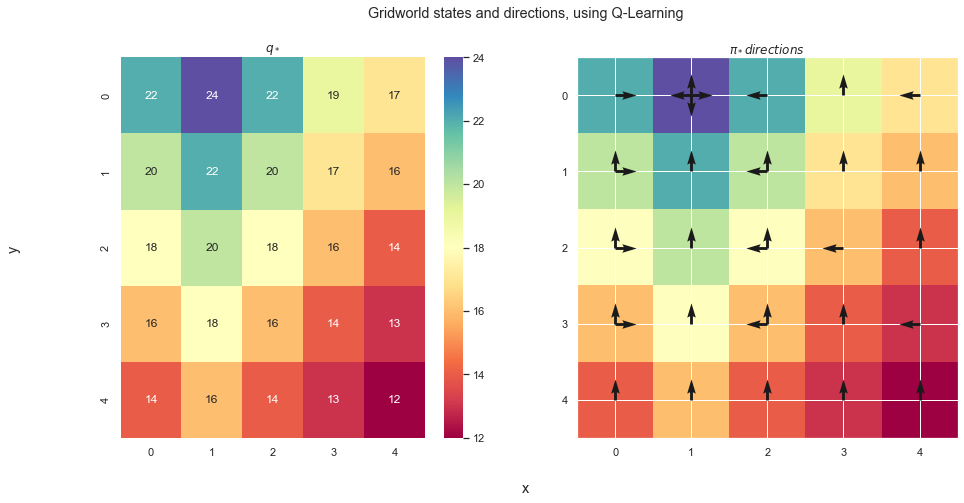

In [44]:
plot_gridworld_results(q_star, q_star_arr)

## Consider playing with the simulation by: 
- changing the locations of the goals
- the number of goals
- changing the size of the grid
- changing the alpha, eta, gamma parameters